In [1]:
#Import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import operator
from statistics import mode, mean

In [3]:
con_data = pd.read_csv("Concrete_Data_Yeh.csv", header=0)
con_data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [5]:
# Using numpy permutation to shuffle data
def shuffle_using_numpy(data):
    temp = np.random.permutation(len(data))
    return data.iloc[temp]

In [7]:

# Normalize (MIN MAX SCALING)
def normalize_strength_dataset(con_data):
    norm = normalization(con_data['cement'].tolist())
    con_data = con_data.assign(cement_Norm=norm)

    norm = normalization(con_data['slag'].tolist())
    con_data = con_data.assign(slag_Norm=norm)

    norm = normalization(con_data['flyash'].tolist())
    con_data = con_data.assign(flyash_Norm=norm)

    norm = normalization(con_data['water'].tolist())
    con_data = con_data.assign(water_Norm=norm)

    norm = normalization(con_data['superplasticizer'].tolist())
    con_data = con_data.assign(superplasticizer_Norm=norm)

    norm = normalization(con_data['coarseaggregate'].tolist())
    con_data = con_data.assign(coarseaggregate_Norm=norm)

    norm = normalization(con_data['fineaggregate'].tolist())
    con_data = con_data.assign(fineaggregate_Norm=norm)

    norm = normalization(con_data['age'].tolist())
    con_data = con_data.assign(age_Norm=norm)
    return con_data


In [14]:
# Part two
# Convert Data from pandas DataFrames to dictionary as keys and values
def data_split_part2(data, normalized):
    x = {}
    y = {}
    # cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
    for k, value in data.iterrows():
        if normalized:
            x[k] = [value['cement_Norm'], value['slag_Norm'], value['flyash_Norm'], value['water_Norm'],
                    value['superplasticizer_Norm'],
                    value['coarseaggregate_Norm'], value['fineaggregate_Norm'], value['age_Norm']]
        else:
            x[k] = [value['cement'], value['slag'], value['flyash'], value['water'], value['superplasticizer'],
                    value['coarseaggregate'], value['fineaggregate'], value['age']]
        y[k] = int(value['csMPa'])

    return x, y

In [19]:
# Get euclidean_distance between features
def get_distance(node1, node2):
    distance = np.linalg.norm(np.array(node1) - np.array(node2))
    return distance

In [20]:
# Normalize datset
def normalization(non_normalized_data):
    minimum = min(non_normalized_data)
    maximum = max(non_normalized_data)
    return [(x - minimum) / (maximum - minimum) for x in non_normalized_data]

In [21]:
min_distance = 0.01

def knn_regression(con_data, weighted, K, normalized):
    folds = 5
    fold_size = len(con_data) // folds
    start = 0
    mae = 0

    for k in range(1, folds + 1):
        test = pd.DataFrame(con_data[start:fold_size * k])

        train = pd.DataFrame(data=None)
        frame2 = con_data[fold_size * k:len(con_data)]
        frame1 = con_data[:start]

        start = start + fold_size

        if len(frame1) == 0:
            train = frame2
        elif len(frame2) == 0:
            train = frame1
        else:
            train = frame1.append(frame2, ignore_index=False)

            # train = con_data - test
        x_train, y_train = data_split_part2(train, normalized)
        x_test, y_test = data_split_part2(test, normalized)
        fold_error = 0
        for k_test, v_test in x_test.items():
            distance = []
            for k_train, v_train in x_train.items():
                euclidean_distance = get_distance(v_train, v_test)
                distance.append((euclidean_distance, k_train))

            distance = sorted(distance)[:K]
            weights = {}
            labels = []
            if weighted:  # Wieghted KNN
                for d in distance:
                    if d[0] != 0:
                        labels.append(y_train[d[1]])
                        if y_train[d[1]] not in weights:
                            weights[y_train[d[1]]] = 1 / d[0]
                        else:
                            weights[y_train[d[1]]] += 1 / d[0]
                    else:
                        labels.append(y_train[d[1]])
                        if y_train[d[1]] not in weights:
                            weights[y_train[d[1]]] = 1 / min_distance
                        else:
                            weights[y_train[d[1]]] += 1 / min_distance
                keys = list(weights.keys())
                weight_vals = list(weights.values())
                prediction = np.average(keys, weights=weight_vals)
                fold_error += abs(y_test[k_test] - prediction)

            else:  # Normal KNN
                for d in distance:
                    labels.append(y_train[d[1]])
                prediction = mean(labels)
                fold_error += abs(y_test[k_test] - prediction)
        fold_total_error = fold_error
        mae += fold_total_error
    #         print("At at Fold", k, " error is =", fold_total_error, " fold total size ",len(x_test))
    print("The MAE after 5 k_folds is {}% \n\n".format(mae / len(con_data)))
    return mae / len(con_data)

In [22]:
# Shuffle and Normalize data set
con_data = shuffle_using_numpy(con_data)

con_data = normalize_strength_dataset(con_data)
# con_data= con_data.sample(frac=1, random_state=42)

In [23]:
non_weighted_non_norm = []
non_weighted_norm = []
weighted_non_norm = []
weighted_norm = []
for k in range(1, 11, 2):
#     print("Non_weight, Non_normliaztion,", end="")
    non_weighted_non_norm.append("%.2f" % knn_regression(con_data, False, k, False))  # non weighted non norm

#     print("Non_weight, normliaztion,", end="")
    non_weighted_norm.append("%.2f" % knn_regression(con_data, False, k, True))  # non weighted norm

#     print("Non_weight, Non_normliaztion,", end="")
    weighted_non_norm.append("%.2f" % knn_regression(con_data, True, k, False))  # weighted non norm

#     print("weight, normliaztion,", end="")

    weighted_norm.append("%.2f" % knn_regression(con_data, True, k, True))  # weighted norm

print("k=1     ", "k=3     ", "k=5     ", "k=7   ", "k=9")
print(non_weighted_non_norm)
print(non_weighted_norm)
print(weighted_non_norm)
print(weighted_norm)


The MAE after 5 k_folds is 6.169902912621359% 


The MAE after 5 k_folds is 6.601941747572815% 


The MAE after 5 k_folds is 6.169902912621359% 


The MAE after 5 k_folds is 6.601941747572815% 


The MAE after 5 k_folds is 6.5249190938511346% 


The MAE after 5 k_folds is 6.7533980582524284% 


The MAE after 5 k_folds is 5.436949570527425% 


The MAE after 5 k_folds is 5.842438289837226% 


The MAE after 5 k_folds is 6.9648543689320395% 


The MAE after 5 k_folds is 7.067572815533977% 


The MAE after 5 k_folds is 5.464822370444512% 


The MAE after 5 k_folds is 5.929564692443822% 


The MAE after 5 k_folds is 7.1525658807212205% 


The MAE after 5 k_folds is 7.269486823855757% 


The MAE after 5 k_folds is 5.505361361320658% 


The MAE after 5 k_folds is 5.984099286747956% 


The MAE after 5 k_folds is 7.3861920172599795% 


The MAE after 5 k_folds is 7.509708737864077% 


The MAE after 5 k_folds is 5.56739117304102% 


The MAE after 5 k_folds is 6.104375132601769% 


k=1      k=3    

In [24]:
print("k=1     ", "k=3     ", "k=5     ", "k=7   ", "k=9")
print("non_weighted_non_norm ",non_weighted_non_norm)
print("non_weighted_norm     ",non_weighted_norm)
print("weighted_non_norm     ",weighted_non_norm)
print("weighted_norm         ",weighted_norm)

k=1      k=3      k=5      k=7    k=9
non_weighted_non_norm  ['6.17', '6.52', '6.96', '7.15', '7.39']
non_weighted_norm      ['6.60', '6.75', '7.07', '7.27', '7.51']
weighted_non_norm      ['6.17', '5.44', '5.46', '5.51', '5.57']
weighted_norm          ['6.60', '5.84', '5.93', '5.98', '6.10']


In [25]:
# Average over different impmentations
import statistics

print(statistics.mean([float(i) for i in non_weighted_non_norm] ))
print(statistics.mean( [float(i) for i in non_weighted_norm] ))
print(statistics.mean([float(i) for i in weighted_non_norm]))
print(statistics.mean([float(i) for i in weighted_norm]))


6.838
7.04
5.63
6.09


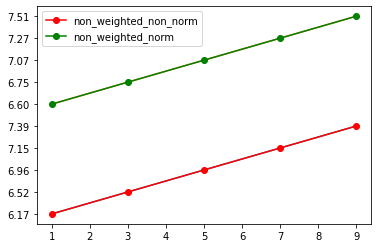

In [26]:
# importing package
import matplotlib.pyplot as plt
  
x = [1,3,5,7,9]
  
plt.plot(x,non_weighted_non_norm)
plt.plot(x,non_weighted_norm)

y = [ non_weighted_non_norm, non_weighted_norm]
labels=['non_weighted_non_norm', 'non_weighted_norm']
colors=['r','g']
# loop over data, labels and colors
for i in range(len(y)):
    plt.plot(x,y[i],'o-',color=colors[i],label=labels[i])

plt.legend()
plt.show()

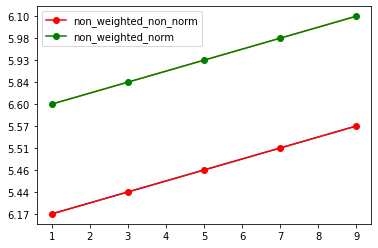

In [27]:
# importing package
import matplotlib.pyplot as plt
  
x = [1,3,5,7,9]
  
plt.plot(x,weighted_non_norm)
plt.plot(x,weighted_norm)

y = [weighted_non_norm, weighted_norm]
labels=['non_weighted_non_norm', 'non_weighted_norm']
colors=['r','g']
# loop over data, labels and colors
for i in range(len(y)):
    plt.plot(x,y[i],'o-',color=colors[i],label=labels[i])

plt.legend()
plt.show()